In [3]:
import torch 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pymatgen.core import Structure
from cdft.dft3d import dft_core
from cdft.pcsaft_eos import pcsaft
from numba import vectorize

device = torch.device('cuda')

In [4]:
m = torch.tensor([1.0], dtype=torch.float64)
sigma = torch.tensor([3.7039], dtype=torch.float64)
epsilon = torch.tensor([150.03], dtype=torch.float64)
parameters = {'m':m, 'sigma':sigma, 'epsilon':epsilon}

In [5]:
structure = Structure.from_file('structures/IRMOF-1.cif')
print('formula:        ', structure.formula)
print('num_sites:      ', structure.num_sites)
print('lattice_lengths:', structure.lattice.lengths)

formula:         Zn32 H96 C192 O104
num_sites:       424
lattice_lengths: (25.832, 25.832, 25.832)


/home/lucas/miniforge3/envs/torch/lib/python3.11/site-packages/pymatgen/io/cif.py:1287: UserWarning: Issues encountered while parsing CIF: Skipping relative stoichiometry check because CIF does not contain formula keys.
  warnings.warn("Issues encountered while parsing CIF: " + "\n".join(self.warnings))


In [6]:
T = 300.0
system_size = np.array([l for l in structure.lattice.lengths])
points = np.array([64, 64, 64])
dft = dft_core(parameters, T, system_size, points, device)

In [7]:
forcefield = pd.DataFrame()
forcefield['type'] = ['Zn','H','C','O']
forcefield['sigma'] = np.array([4.045, 2.846, 3.47299, 3.033])
forcefield['epsilon'] = np.array([27.677, 7.6489, 47.8562, 48.1581])
forcefield['mass'] = np.array([65.38, 1.00784, 12.0107, 15.999])

X,Y,Z = np.meshgrid(dft.x, dft.y, dft.z, indexing='ij')

@vectorize
def lj_potential(r,sigma,epsilon):
    if r == 0:
        V = np.inf
    elif r > 4*3.7039:
        V = 0.0
    else:
        V = 4.0*epsilon*((sigma/r)**12-(sigma/r)**6) 
    return V 

Vext = np.zeros((dft.Nc, points[0], points[1], points[2]), dtype=np.float64)
for i in range(dft.Nc):
    for k, site in enumerate(structure):
        sigmasf = float(0.5*(sigma[i].numpy()+forcefield['sigma'][forcefield['type']==site.species_string]))
        epsilonsf = float(np.sqrt(epsilon[i].numpy()*forcefield['epsilon'][forcefield['type']==site.species_string]))
        rx = X-structure.cart_coords[k,0] 
        ry = Y-structure.cart_coords[k,1] 
        rz = Z-structure.cart_coords[k,2] 
        rx -= system_size[0]*(rx/system_size[0]).round()
        ry -= system_size[1]*(ry/system_size[1]).round()
        rz -= system_size[2]*(rz/system_size[2]).round()
        r = np.sqrt(rx**2+ry**2+rz**2)
        Vext[i] += m[i].numpy()*lj_potential(r,sigmasf,epsilonsf)

/tmp/ipykernel_5963/1769529379.py:22: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  sigmasf = float(0.5*(sigma[i].numpy()+forcefield['sigma'][forcefield['type']==site.species_string]))
/tmp/ipykernel_5963/1769529379.py:23: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  epsilonsf = float(np.sqrt(epsilon[i].numpy()*forcefield['epsilon'][forcefield['type']==site.species_string]))
/tmp/ipykernel_5963/1769529379.py:22: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  sigmasf = float(0.5*(sigma[i].numpy()+forcefield['sigma'][forcefield['type']==site.species_string]))
/tmp/ipykernel_5963/1769529379.py:23: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in t

Text(0, 0.5, '$y$ (\\AA{})')

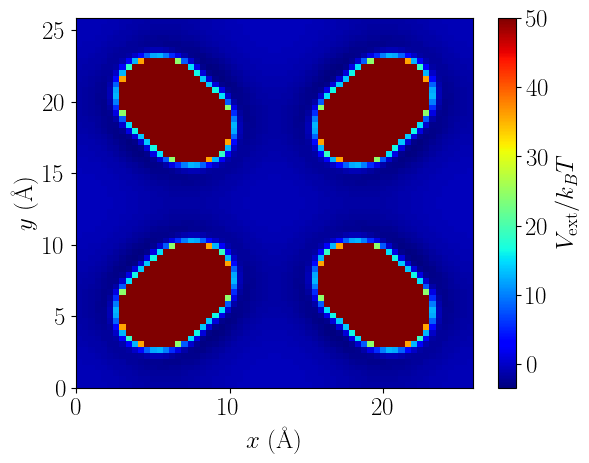

In [8]:
plt.rcParams.update({'text.usetex':True, 
'font.family':'serif', 
'font.size':18, 
# 'axes.linewidth':1.1, 
'lines.linewidth':1.6,
'legend.fontsize': 18,
'legend.frameon':False
#'figure.figsize':(7.9, 6.1)
})


plt.figure()
c=plt.pcolormesh(X[:,:,points[0]//2],Y[:,:,points[1]//2],Vext[0,:,:,points[2]//2]/T, vmax=50.0, cmap='jet')
plt.colorbar(label=r'$V_{\mathrm{ext}}/k_B T$')
plt.xlabel(r'$x$ (\AA{})')
plt.ylabel(r'$y$ (\AA{})')

In [9]:
P = torch.hstack((torch.arange(1e5,1e6,1e5,dtype=torch.float64), torch.range(1e6,1e7,1e6,dtype=torch.float64)))
bulk_density = torch.empty_like(P)
composition = torch.tensor([1.0],dtype=torch.float64)

eos = pcsaft(parameters, T)
bulk_density[0] = eos.density(P[0],composition,'vap')
for i in range(1,len(P)):
    bulk_density[i] = eos.density(P[i],composition,bulk_density[i-1])

/tmp/ipykernel_5963/2670556039.py:1: UserWarning: torch.range is deprecated and will be removed in a future release because its behavior is inconsistent with Python's range builtin. Instead, use torch.arange, which produces values in [start, end).
  P = torch.hstack((torch.arange(1e5,1e6,1e5,dtype=torch.float64), torch.range(1e6,1e7,1e6,dtype=torch.float64)))


In [10]:
dft.initial_condition(bulk_density[0],composition,Vext)

In [11]:
Nads = torch.empty((dft.Nc,len(P)),dtype=torch.float64)
for i in range(len(P)):
    dft.equilibrium_density_profile(bulk_density[i],composition,fmt='ASWB',
                                    solver='fire',alpha0=0.2,dt=0.1,tol=1e-6,logoutput=False)
    for j in range(dft.Nc):
        Nads[j,i] = dft.total_molecules[j]
    print(dft.it,dft.error.numpy(),1e-5*P[i].numpy(),Nads[:,i].numpy())
    if np.isnan(dft.error.numpy()): break

112 9.539269073254548e-07 1.0 [2.76356667]
89 9.26016435312647e-07 2.0 [5.5863537]
89 6.328189982137918e-07 3.0000000000000004 [8.4577605]
89 2.2156146546584692e-07 4.0 [11.36565387]
88 6.758063593753004e-07 5.0 [14.29663359]
87 8.190073407647493e-07 6.000000000000001 [17.2365386]
86 6.052944773198899e-07 7.000000000000001 [20.17113177]
85 7.152822321697303e-07 8.0 [23.08652052]
86 9.642953934971373e-07 9.0 [25.96979537]
84 9.920761034698219e-07 10.0 [28.80946957]
135 9.321725440931423e-07 20.0 [53.43688508]
133 9.133681355217619e-07 30.000000000000004 [70.8291451]
126 9.87463780373853e-07 40.0 [83.00934614]
108 9.246758084849191e-07 50.00000000000001 [91.89008215]
116 5.807982866122151e-07 60.00000000000001 [98.65005544]
115 9.024734964687319e-07 70.0 [103.9861769]
114 9.814848004472783e-07 80.0 [108.32391217]
113 9.706018907649664e-07 90.00000000000001 [111.93522997]
113 9.096712474541565e-07 100.00000000000001 [115.00160513]


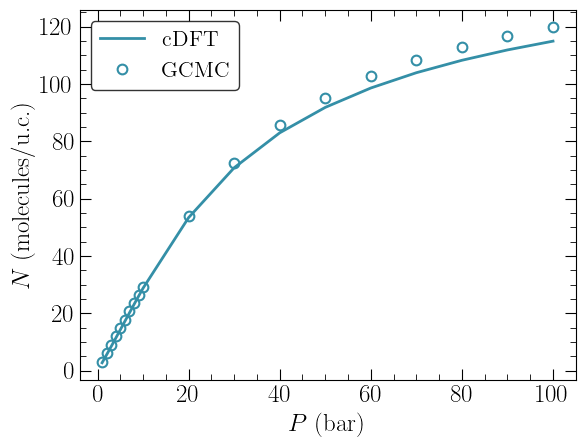

In [13]:
data = pd.read_pickle('data/isotherm_methane.pkl')

import seaborn as sns

colors = sns.color_palette("mako")

plt.rcParams.update({'text.usetex':True, 
'font.family':'serif',  
#'figure.figsize':(7.9, 6.1)
})

plt.plot(P*1e-5, Nads[0], '-', color=colors[3], linewidth=2.0, label='cDFT')
plt.plot(data['pressure'], data['methane'], 'o', color=colors[3],markersize=7,markeredgewidth=1.5,mfc='none',label='GCMC')
plt.xlabel(r'$P$ (bar)', fontsize=18)
plt.ylabel(r'$N$ (molecules/u.c.)', fontsize=18)
# plt.xlim([0.0,125])
# plt.ylim([None,0.004])
plt.minorticks_on()
plt.tick_params(direction='in',right=True, top=True)
plt.tick_params(labelsize=18)
plt.tick_params(labelbottom=True, labeltop=False, labelright=False, labelleft=True)
# xticks = np.arange(0, 1e4,10)
# yticks = np.arange(0,16.1,4)
plt.tick_params(direction='in',which='minor', length=4, bottom=True, top=True, left=True, right=True)
plt.tick_params(direction='in',which='major', length=8, bottom=True, top=True, left=True, right=True)
# plt.xticks(xticks)
# plt.yticks(yticks)
plt.legend(fontsize=16, frameon=True, edgecolor='k')
# plt.savefig('figures/isotherm_methane.pdf', bbox_inches='tight')